In [1]:
# Cell 1: Imports
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

sys.path.insert(0, os.path.abspath('../src'))

from models.gbm import GeometricBrownianMotion

# Plot style
plt.style.use('seaborn-v0_8-darkgrid')
print("Setup complete.")

Setup complete.


In [2]:
gbm_params = {
    'S0': 100,     # Start price
    'mu': 0.05,    # 5% annual drift
    'sigma': 0.2   # 20% annual volatility
}

gbm_model = GeometricBrownianMotion(**gbm_params)
print(f"Model created: {gbm_model}")

# Simulation settings
T = 1     # 1 year
dt = 1/252    # Daily steps
n_paths = 10

sim_paths = gbm_model.simulate(T, dt, n_paths)

print(f"Path array shape: {sim_paths.shape}")

Model created: GeometricBrownianMotion({'S0': 100, 'mu': 0.05, 'sigma': 0.2})
Path array shape: (253, 10)


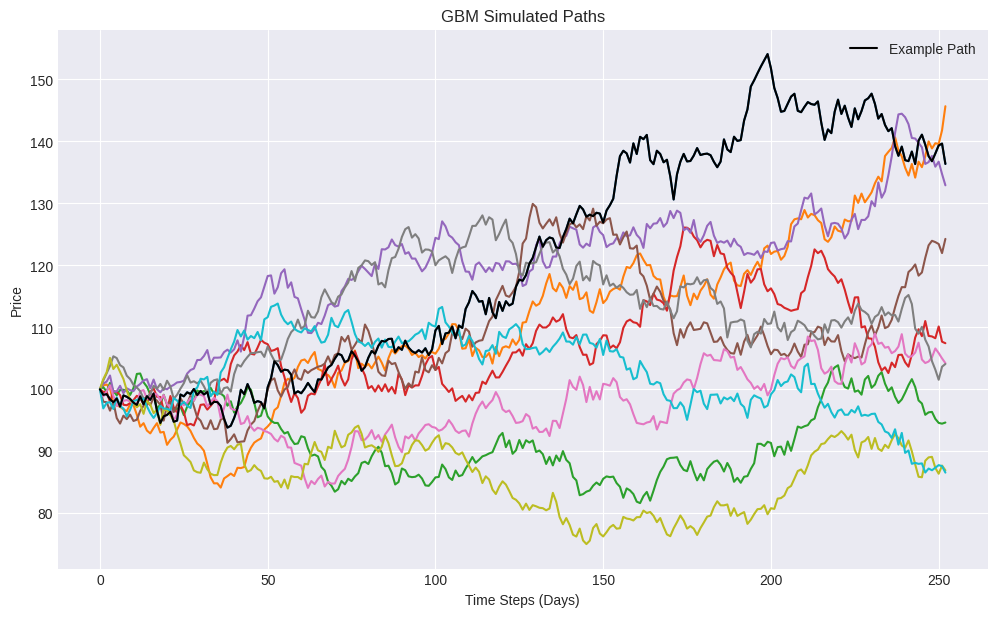

In [3]:
plt.figure(figsize=(12, 7))
plt.plot(sim_paths)

# Plotting the first path in black to make it stand out
plt.plot(sim_paths[:, 0], color='black', linewidth=1.5, label="Example Path")

plt.title("GBM Simulated Paths")
plt.xlabel("Time Steps (Days)")
plt.ylabel("Price")
plt.legend()
plt.show()

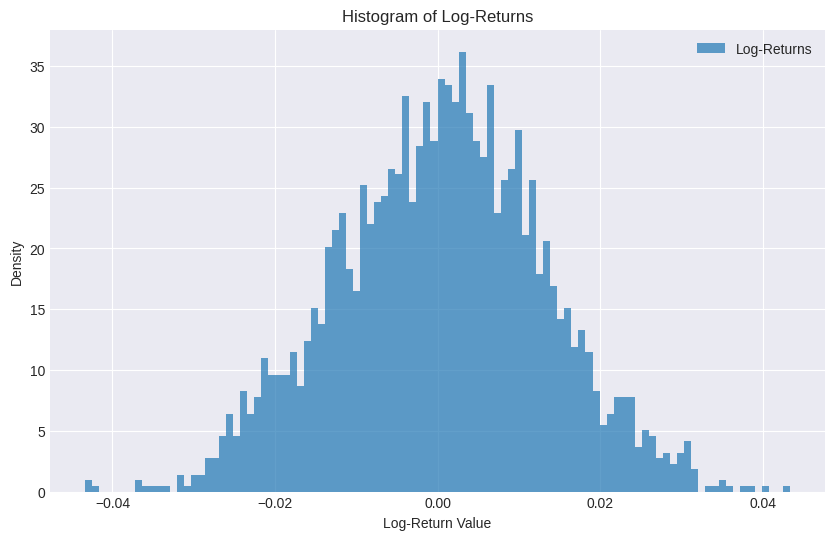

In [4]:
# Validation - Checking log-returns
# Log returns should be normally distributed
# Get log returns: log(S_t / S_{t-1})
# Need [1:] and [:-1] to align the arrays
log_returns = np.log(sim_paths[1:] / sim_paths[:-1])

# Flatten all returns into one big 1D array
all_log_returns = log_returns.flatten()

# Plot a histogram
plt.figure(figsize=(10, 6))
plt.hist(all_log_returns, bins=100, density=True, alpha=0.7, label="Log-Returns")
plt.title("Histogram of Log-Returns")
plt.xlabel("Log-Return Value")
plt.ylabel("Density")
plt.legend()
plt.show()